In [9]:
import pandas as pd
import numpy as np

book_ratings = pd.read_csv("BX-Book-Ratings.csv", encoding='ISO-8859-1', on_bad_lines='skip')
books = pd.read_csv("BX-Books.csv", encoding='ISO-8859-1', on_bad_lines='skip')
users = pd.read_csv("BX-Users.csv", encoding='ISO-8859-1', on_bad_lines='skip')
movies = pd.read_csv("movies.csv", encoding='ISO-8859-1', on_bad_lines='skip')
ratings = pd.read_csv("ratings.csv", encoding='ISO-8859-1', on_bad_lines='skip')
links = pd.read_csv("links.csv", encoding='ISO-8859-1', on_bad_lines='skip')
tags = pd.read_csv("tags.csv", encoding='ISO-8859-1', on_bad_lines='skip')

In [10]:
#For Movies (1a)
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'])
ratings = ratings.fillna(0)

try:
    user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
except ValueError as e:
    print(f" {e}")
    user_movie_matrix = None

top_movies = ratings['movieId'].value_counts().head(3)
top_movie_titles = pd.read_csv("movies.csv").set_index('movieId').loc[top_movies.index]['title']
print("Top 3 Movies by No. Ratings:")
for title, count in zip(top_movie_titles, top_movies):
    print(f"{title}: {count} ratings")

top_users_movies = ratings['userId'].value_counts().head(3)
print("\nTop 3 Users by their Movie Ratings:")
for user, count in top_users_movies.items():
    print(f"UserId {user}: {count} movies rated")

C:\Users\shind\anaconda3\Lib\site-packages\pandas\core\reshape\reshape.py:143: RuntimeWarning: overflow encountered in scalar multiply
  num_cells = num_rows * num_columns


 negative dimensions are not allowed
Top 3 Movies by No. Ratings:
Shawshank Redemption, The (1994): 102929 ratings
Forrest Gump (1994): 100296 ratings
Pulp Fiction (1994): 98409 ratings

Top 3 Users by their Movie Ratings:
UserId 175325: 33332 movies rated
UserId 17035: 9577 movies rated
UserId 55653: 9178 movies rated


In [11]:
#For books (1b)
book_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')

book_ratings['Book-Rating'] = book_ratings['Book-Rating'].replace(0, pd.NA) 
mean_ratings = book_ratings.groupby('ISBN')['Book-Rating'].transform('mean')
book_ratings['Book-Rating'] = book_ratings['Book-Rating'].fillna(mean_ratings)

book_ratings_counts = book_ratings['ISBN'].value_counts()
books_rated_at_least_200 = book_ratings_counts[book_ratings_counts >= 200].index
book_ratings_filtered = book_ratings[book_ratings['ISBN'].isin(books_rated_at_least_200)]

user_book_matrix = book_ratings_filtered.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating', fill_value=0)

top_books = book_ratings_filtered['ISBN'].value_counts().head(3)
top_book_titles = books.set_index('ISBN').loc[top_books.index]['Book-Title']
print("Top 3 Books by Number of Ratings:")
for title, count in zip(top_book_titles, top_books):
    print(f"{title}: {count} ratings")

top_users_books = book_ratings_filtered['User-ID'].value_counts().head(3)
print("\nTop 3 Users by Number of Book Ratings:")
for user, count in top_users_books.items():
    print(f"UserId {user}: {count} books rated")

C:\Users\shind\AppData\Local\Temp\ipykernel_21980\312488345.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
C:\Users\shind\AppData\Local\Temp\ipykernel_21980\312488345.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  book_ratings['Book-Rating'] = book_ratings['Book-Rating'].fillna(mean_ratings)  # Fill missing values with the mean rating


Top 3 Books by Number of Ratings:
Wild Animus: 2502 ratings
The Lovely Bones: A Novel: 1295 ratings
The Da Vinci Code: 883 ratings

Top 3 Users by Number of Book Ratings:
UserId 11676: 193 books rated
UserId 35859: 121 books rated
UserId 16795: 119 books rated


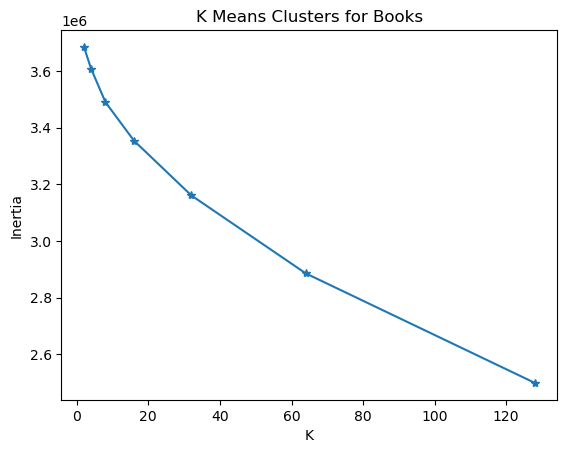

In [19]:
#K Means clustering (2a)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = [2,4,8,16,32,64,128]
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_book_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker="*")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("K Means Clusters for Books")
plt.show()

#It seems like 128 is the best K-value since it has the lowest inertia out of all of them.

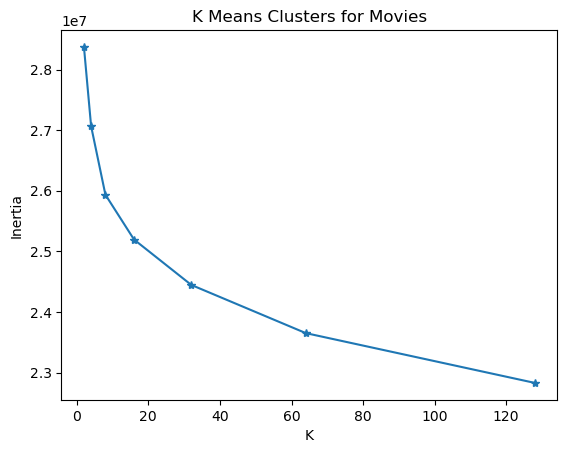

In [141]:
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)
user_movie_matrix = user_movie_matrix.astype(float)

k_values = [2, 4, 8, 16, 32, 64, 128]
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_movie_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker="*")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("K Means Clusters for Movies")
plt.show()

#128 is the best k value since the inertia is lowest.

In [145]:
top_books_per_cluster = {}

for cluster in range(k):
    cluster_users = user_book_matrix[user_book_matrix['Cluster'] == cluster]
    cluster_book_ratings = cluster_users.drop(columns=['Cluster']).mean()
    top_books = cluster_book_ratings.sort_values(ascending=False).head(3).index
    
    top_books_titles = books.set_index('ISBN').reindex(top_books)['Book-Title']
    top_books_per_cluster[cluster] = top_books_titles.dropna()

for cluster, titles in top_books_per_cluster.items():
    print(f"\K = {cluster} - Top 3:")
    for title in titles:
        print(f"- {title}")



Cluster 0 - Top 3 Books:
- The Five People You Meet in Heaven
- The Lovely Bones: A Novel
- The Da Vinci Code

Cluster 1 - Top 3 Books:
- Seabiscuit: An American Legend
- The Lovely Bones: A Novel
- Bel Canto: A Novel

Cluster 2 - Top 3 Books:
- I Know This Much Is True
- She's Come Undone (Oprah's Book Club (Paperback))
- Lucky : A Memoir

Cluster 3 - Top 3 Books:
- Wild Animus
- The Brethren
- The Alchemist: A Fable About Following Your Dream

Cluster 4 - Top 3 Books:
- The Secret Life of Bees
- The Lovely Bones: A Novel

Cluster 5 - Top 3 Books:
- A Painted House
- One Door Away from Heaven
- Bridget Jones: The Edge of Reason

Cluster 6 - Top 3 Books:
- The Saving Graces: A Novel
- Dance upon the Air (Three Sisters Island Trilogy)
- Summer Sisters

Cluster 7 - Top 3 Books:
- She's Come Undone (Oprah's Book Club (Paperback))
- The Book of Ruth (Oprah's Book Club (Paperback))
- Icy Sparks

Cluster 8 - Top 3 Books:
- The Book of Ruth (Oprah's Book Club (Paperback))
- A Map of the Worl

In [148]:
k = 128
kmeans = KMeans(n_clusters=k, random_state=42)
user_movie_matrix['Cluster'] = kmeans.fit_predict(user_movie_matrix)

top_movies_per_cluster = {}

for cluster in range(k):
    cluster_users = user_movie_matrix[user_movie_matrix['Cluster'] == cluster] 
    cluster_movie_ratings = cluster_users.drop(columns=['Cluster']).mean()  
    top_movies = cluster_movie_ratings.sort_values(ascending=False).head(3).index 

    top_movie_titles = movies.set_index('movieId').reindex(top_movies)['title']
    top_movies_per_cluster[cluster] = top_movie_titles.dropna() 

for cluster, titles in top_movies_per_cluster.items():
    print(f"\nCluster {cluster} - Top 3 Movies:")
    for title in titles:
        print(f"- {title}")



Cluster 0 - Top 3 Movies:
- Lion King, The (1994)
- Beauty and the Beast (1991)
- Little Mermaid, The (1989)

Cluster 1 - Top 3 Movies:
- Apollo 13 (1995)
- Pulp Fiction (1994)
- Dances with Wolves (1990)

Cluster 2 - Top 3 Movies:
- Iron Man (2008)
- Forrest Gump (1994)
- Lord of the Rings: The Return of the King, The (2003)

Cluster 3 - Top 3 Movies:
- Toy Story (1995)
- Twelfth Night (1996)
- Fish Called Wanda, A (1988)

Cluster 4 - Top 3 Movies:
- Donnie Darko (2001)
- Usual Suspects, The (1995)
- Big Lebowski, The (1998)

Cluster 5 - Top 3 Movies:
- Usual Suspects, The (1995)
- Pulp Fiction (1994)
- Memento (2000)

Cluster 6 - Top 3 Movies:
- Alien (1979)
- Monty Python and the Holy Grail (1975)
- Pulp Fiction (1994)

Cluster 7 - Top 3 Movies:
- Matrix, The (1999)
- Inception (2010)
- Fight Club (1999)

Cluster 8 - Top 3 Movies:
- Bourne Identity, The (2002)
- Trainspotting (1996)
- Fitzcarraldo (1982)

Cluster 9 - Top 3 Movies:
- Forrest Gump (1994)
- Groundhog Day (1993)
- Toy 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


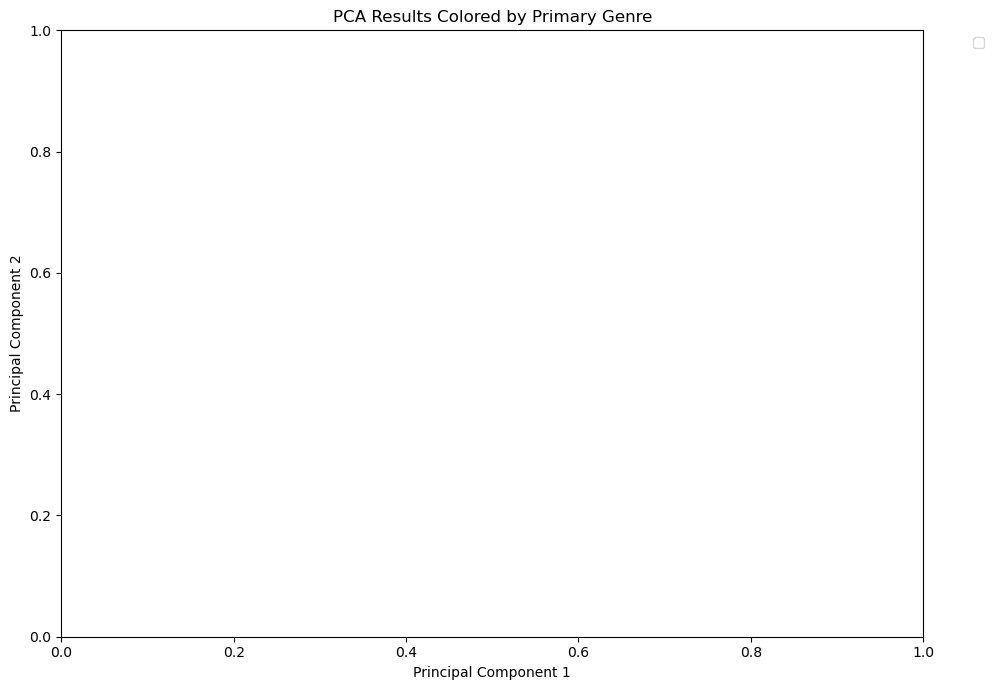

Number of components needed to explain 80% variance: 1
Number of components needed to explain 40% variance: 1


In [213]:
#Q3 - PCA

from sklearn.decomposition import PCA

movie_user_matrix = user_movie_matrix.drop(columns=['Cluster']).T 
mean_centered_data = movie_user_matrix - movie_user_matrix.mean(axis=1).values.reshape(-1, 1)

pca = PCA(n_components=2)
reduced = pca.fit_transform(mean_centered_data)
movies['Primary Genre'] = movies['genres'].str.split('|').str[0]

results = pd.DataFrame(reduced, columns=['PC1', 'PC2'], index=movie_user_matrix.index)
results = results.merge(movies[['Primary Genre']], left_index=True, right_index=True)

plt.figure(figsize=(10, 7))
for genre, group in results.groupby('Primary Genre'):
    plt.scatter(group['PC1'], group['PC2'], label=genre, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results Colored by Primary Genre')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
var = pca.explained_variance_ratio_

cum = np.cumsum(var)
components_80 = np.argmax(cum >= 0.80) + 1
components_40 = np.argmax(cum >= 0.40) + 1

print(f"Number of components needed to explain 80% variance: {components_80}")
print(f"Number of components needed to explain 40% variance: {components_40}")

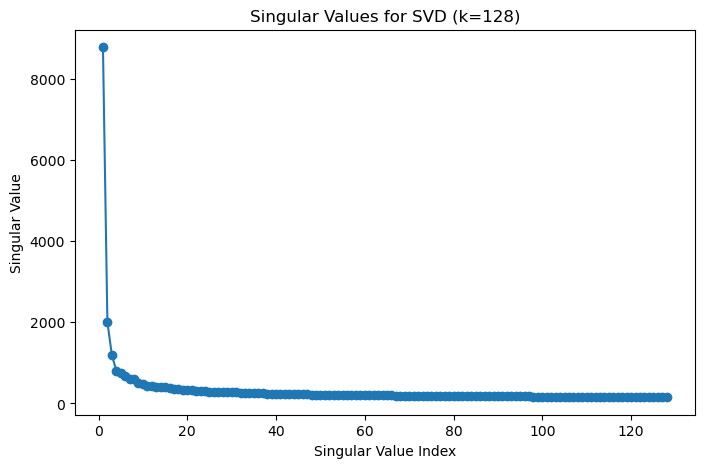

In [158]:
#Q4 - SVD


from sklearn.decomposition import TruncatedSVD

user_movie_matrix.columns = user_movie_matrix.columns.astype(str)

k = 128
svd = TruncatedSVD(n_components=k, random_state=42)
svd.fit(user_movie_matrix)

plt.figure(figsize=(8, 5))
plt.plot(range(1, k + 1), svd.singular_values_, marker="o")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.title("Singular Values for SVD (k=128)")
plt.show()


In [162]:
user_movie_matrix.columns = user_movie_matrix.columns.astype(str)

k_values = [2, 4, 8, 16, 32, 64, 128]

ratios = {}

for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(user_movie_matrix)
    sums = svd.explained_variance_ratio_.sum()
    ratios[k] = sums
    print(f"Sum of explained variance ratio for k={k}: {sums:.4f}")



Sum of explained variance ratio for k=2: 0.4473
Sum of explained variance ratio for k=4: 0.4893
Sum of explained variance ratio for k=8: 0.5244
Sum of explained variance ratio for k=16: 0.5543
Sum of explained variance ratio for k=32: 0.5841
Sum of explained variance ratio for k=64: 0.6163
Sum of explained variance ratio for k=128: 0.6557


In [161]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
t_data = svd2.fit_transform(user_movie_matrix)

# Display the transformed data shape
print(f"Transformed Data Shape: {t_data.shape}")

Transformed Data Shape: (15513, 2)


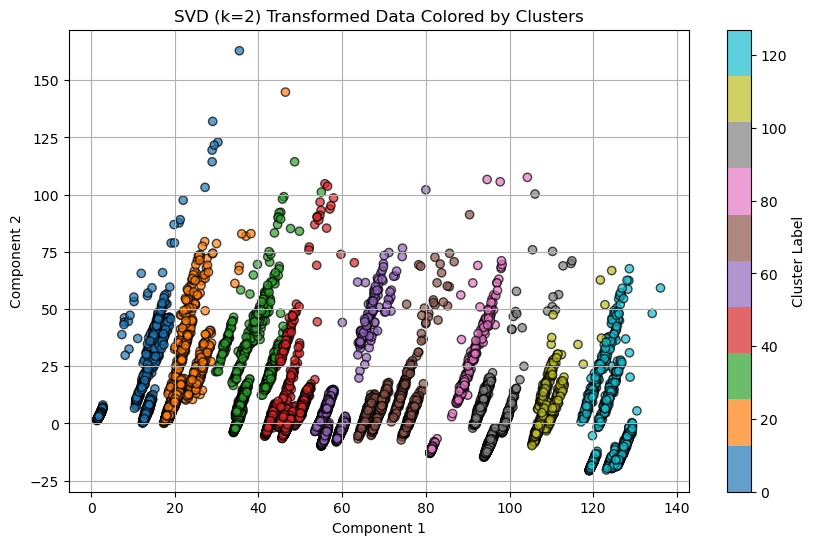

In [168]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

svd2 = TruncatedSVD(n_components=2, random_state=42)
t_data = svd2.fit_transform(user_movie_matrix)
users = pd.Series(kmeans.labels_, index=user_movie_matrix.index, name='Cluster')


labels = users.values

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    t_data[:, 0],
    t_data[:, 1],
    c=labels,
    cmap='tab10',
    alpha=0.7,
    edgecolors='k'
)

plt.colorbar(scatter, label='Cluster Label')
plt.title("SVD (k=2) Transformed Data Colored by Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()

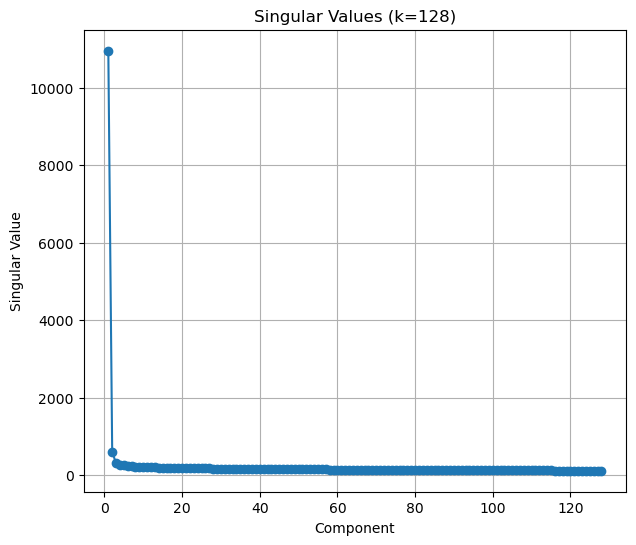

Sum of explained variance ratio for k=2: 0.9185
Sum of explained variance ratio for k=4: 0.9222
Sum of explained variance ratio for k=8: 0.9271
Sum of explained variance ratio for k=16: 0.9341
Sum of explained variance ratio for k=32: 0.9448
Sum of explained variance ratio for k=64: 0.9610
Sum of explained variance ratio for k=128: 0.9841
Transformed data shape: (21557, 2)


C:\Users\shind\AppData\Local\Temp\ipykernel_21980\3892379101.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


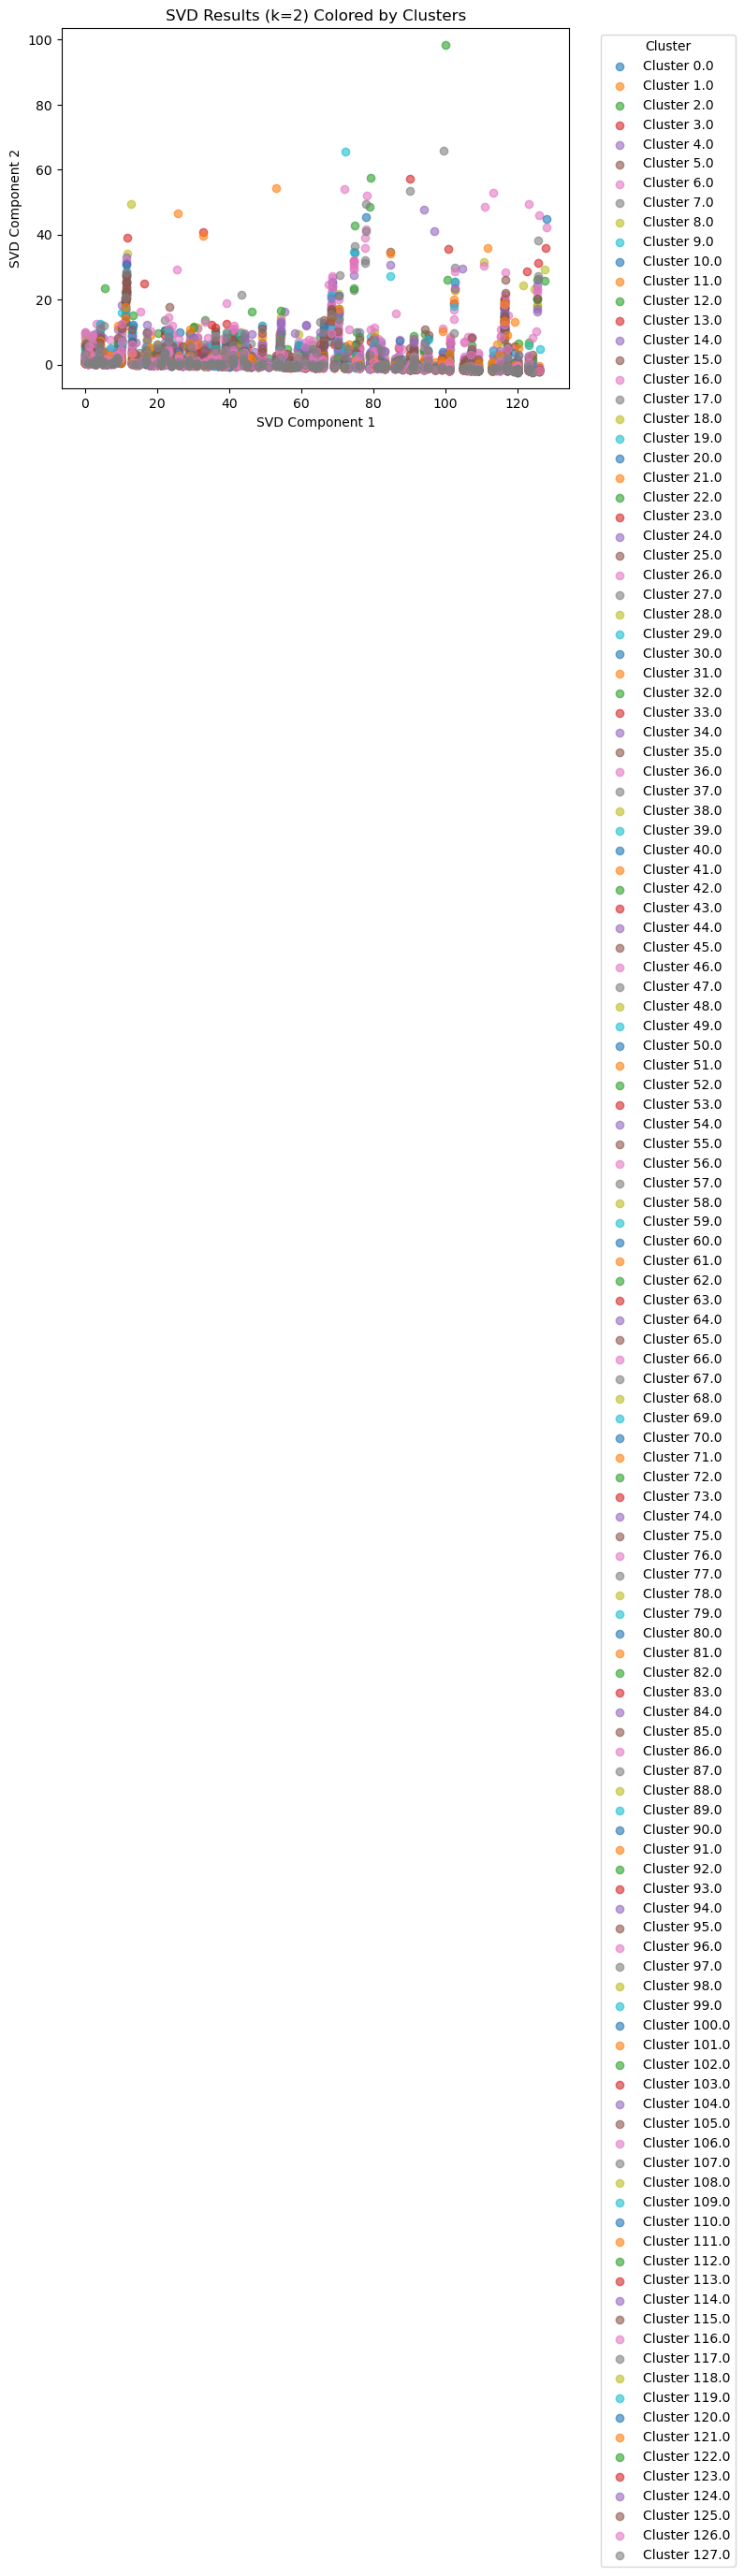

In [209]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

svd_128 = TruncatedSVD(n_components=128)
svd_128.fit(user_book_matrix)

plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, len(svd_128.singular_values_) + 1), svd_128.singular_values_, marker='o')
plt.title('Singular Values (k=128)')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.grid()
plt.show()


k_values = [2, 4, 8, 16, 32, 64, 128]
ratios = {}

for k in k_values:
    svd = TruncatedSVD(n_components=k)
    svd.fit(user_book_matrix)
    ratios[k] = svd.explained_variance_ratio_.sum()

for k, ratio in ratios.items():
    print(f"Sum of explained variance ratio for k={k}: {ratio:.4f}")


svd2 = TruncatedSVD(n_components=2)
books2 = svd2.fit_transform(user_book_matrix)

print("Transformed data shape:", books2.shape)



output = pd.DataFrame(books2, columns=['SVD1', 'SVD2'], index=user_book_matrix.index)
output['Cluster'] = user_clusters

plt.figure(figsize=(7, 5))
for cluster, group in output.groupby('Cluster'):
    plt.scatter(group['SVD1'], group['SVD2'], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('SVD Results (k=2) Colored by Clusters')
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
